In [1]:
%reset -f

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
# Some useful functions
def show_image(image,title="",c_stretch=True,cmap=None):
    if c_stretch:
        vmin = image.min()
        vmax = image.max()
    else:
        vmin = 0
        vmax = 255
    
    plt.imshow(image,vmin=vmin,vmax=vmax,cmap=cmap)
    plt.axis("off")
    plt.title(title)

In [57]:
image_num = 7

input1 = str(image_num) + "a.jpg"
input2 = str(image_num) + "b.jpg"

output = str(image_num) + ".jpg"

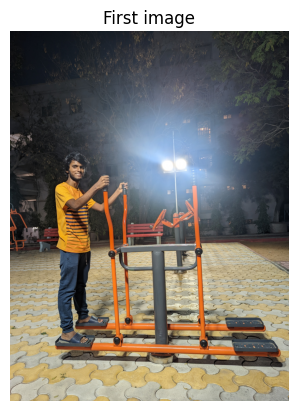

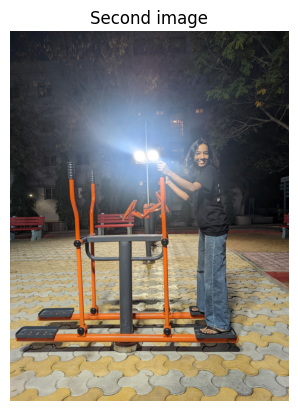

In [58]:
# Importing images
man = cv.imread(f"../data/inputs/{input1}")
man = cv.cvtColor(man,cv.COLOR_BGR2RGB)
man2 = cv.imread(f"../data/inputs/{input2}")
man2 = cv.cvtColor(man2,cv.COLOR_BGR2RGB)

show_image(man,"First image")
plt.figure()
show_image(man2,"Second image")

## Color Normalization

In [59]:
def histMatching(image, ref_image):
    out = image.copy()

    intensity_range = range(256)

    # Get all the unique pixels and their counts
    pixels_in, counts_in = np.unique(image, return_counts=True)
    pixels_ref, counts_ref = np.unique(ref_image, return_counts=True)
    
    # Filling in missing values with 0 counts
    for i in intensity_range:
        if i not in pixels_in:
            pixels_in = np.insert(pixels_in,i,i)
            counts_in = np.insert(counts_in,i,0)
        if i not in pixels_ref:
            pixels_ref = np.insert(pixels_ref,i,i)
            counts_ref = np.insert(counts_ref,i,0)

    # Get probabilities of each intensity value for both images
    prob_in = counts_in/(counts_in.sum())
    prob_ref = counts_ref/(counts_ref.sum())

    # Get cumulative probabilities of both images
    cmf_in = np.cumsum(prob_in)
    cmf_ref = np.cumsum(prob_ref)
    
    # Histogram equalization for both images
    eq_in = np.round(255*cmf_in[intensity_range])
    eq_ref = np.round(255*cmf_ref[intensity_range])
    
    # output as an inverse of the equalized reference image wrt input image
    out = np.searchsorted(eq_ref,eq_in[image],side="left")

    return out


In [60]:
man_lab = cv.cvtColor(man,cv.COLOR_RGB2LAB)
man2_lab = cv.cvtColor(man2,cv.COLOR_RGB2LAB)

man_l = man_lab[:,:,0]
man2_l = man2_lab[:,:,0]
hist_out = man_lab.copy()
hist_out[:,:,0] = hist_out_l = histMatching(man_l,man2_l)
hist_out = cv.cvtColor(hist_out,cv.COLOR_LAB2RGB)

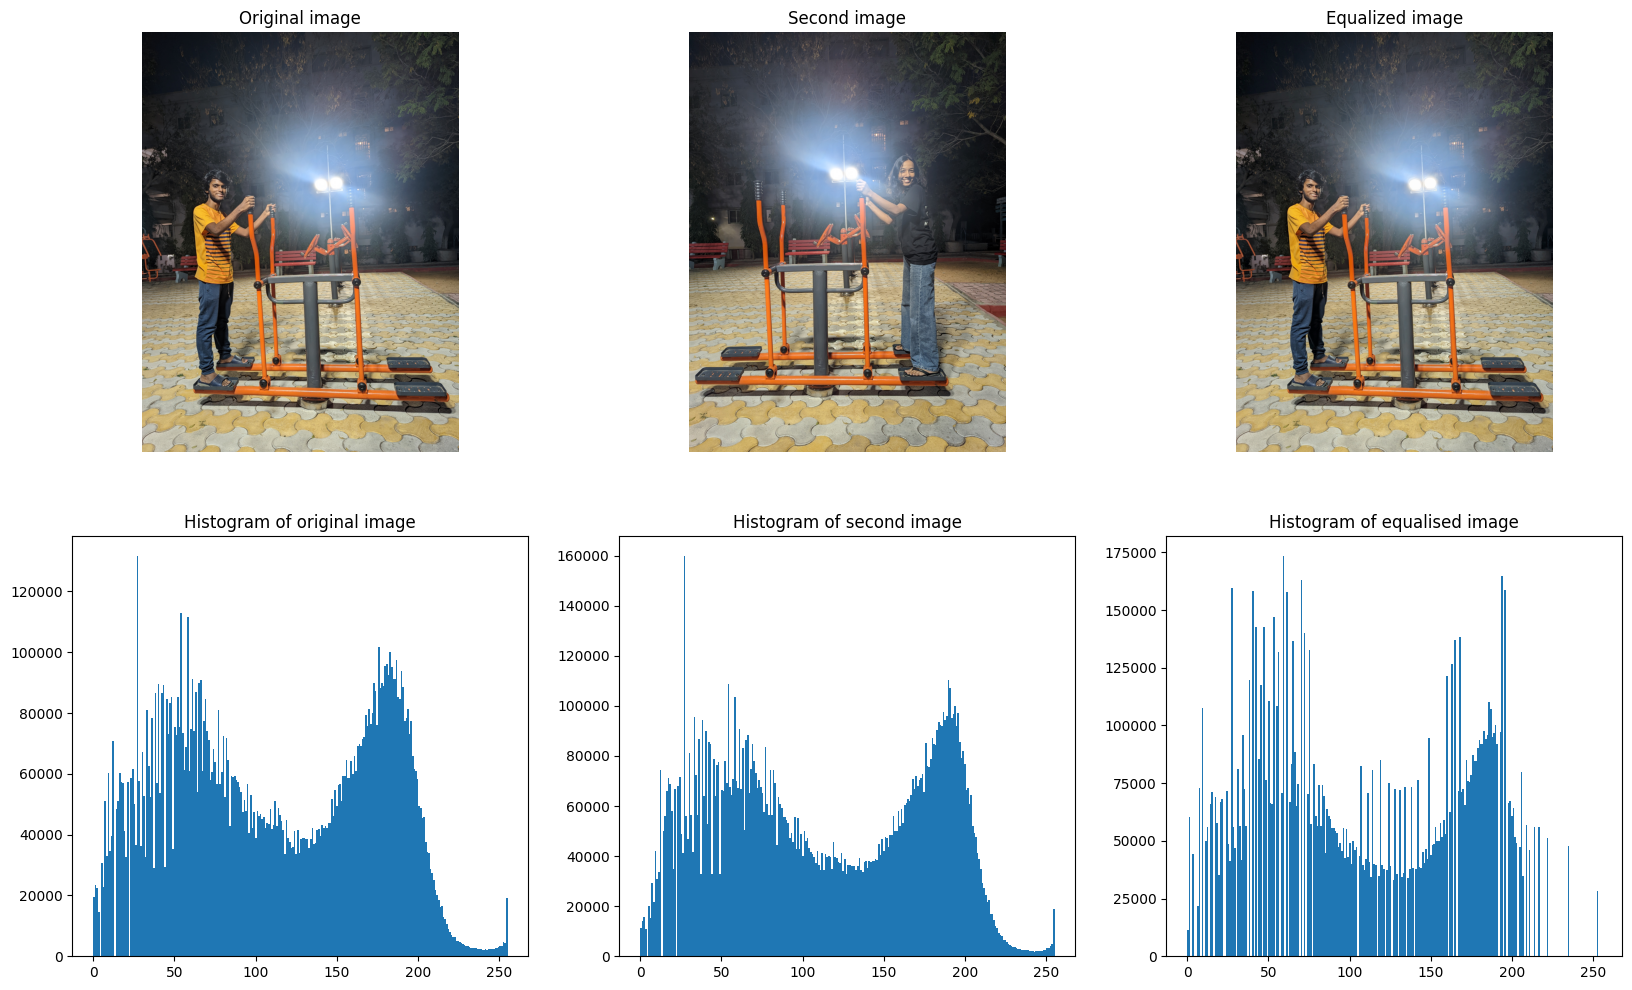

In [61]:
fig = plt.figure(figsize = (20,12))
plt.subplot(2,3,1)
show_image(man, "Original image")
plt.subplot(2,3,2)
show_image(man2, "Second image")
plt.subplot(2,3,3)
show_image(hist_out, "Equalized image")

plt.subplot(2,3,4)
plt.hist(man2_l.ravel(),256,[0,255])
plt.title('Histogram of original image')
plt.subplot(2,3,5)
plt.hist(man_l.ravel(),256,[0,255])
plt.title('Histogram of second image')
plt.subplot(2,3,6)
plt.hist(hist_out_l.ravel(),256,[0,255])
plt.title('Histogram of equalised image')
plt.show()

In [62]:
man = hist_out
man2 = man2

## Keypoints

### Detection

In [63]:
def find_keypoints(img1, img2):
    # Initiate ORB detector
    orb = cv.ORB_create()

    # find the keypoints with ORB
    kp1 = orb.detect(img1, None)
    kp2 = orb.detect(img2, None)

    # compute the descriptors with ORB
    kp1, des1 = orb.compute(img1, kp1)
    kp2, des2 = orb.compute(img2, kp2)

    return kp1, kp2, des1, des2

def match_keypoints(des1, des2):
    bf = cv.BFMatcher.create(cv.NORM_HAMMING, crossCheck=True)    # this should be brute force hamming
    matches = bf.match(des1, des2)
    sorted_matches = sorted(matches, key=lambda x: x.distance, reverse=True)
    return sorted_matches
    
# Prune matches based distance attribute
def prune_keypoint_matches_by_distance(matches):
    FACTOR = 10
    pruned_matches = []
    threshold = matches[-1].distance * FACTOR
    for m in matches:
        if m.distance < threshold:
            pruned_matches.append(m)
    return pruned_matches

# Print lines that connect matching keypoints across two images
def display_keypoint_matches(img1, img2, kp1, kp2, matches):
    concat_image = np.concatenate((img1, img2), axis=1)
    h, w = img1.shape[:2]
    for m in matches:
        color = (0, 255, 0)
        cv.line(concat_image, (int(kp1[m.queryIdx].pt[0]), int(kp1[m.queryIdx].pt[1])), (int(kp2[m.trainIdx].pt[0] + w), int(kp2[m.trainIdx].pt[1])), color)
    
    show_image(concat_image, "Keypoint matches")



### Matching

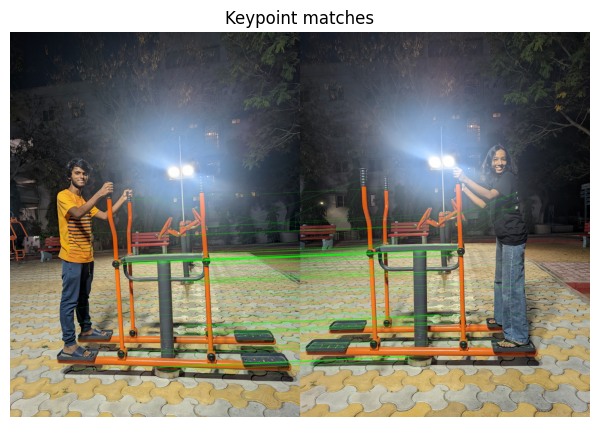

In [64]:
# crop img1 to img2 size
out_dim = (min(man.shape[0],man2.shape[0]),min(man.shape[1],man2.shape[1]))
man = man[:out_dim[0], :out_dim[1]]
man2 = man2[:out_dim[0], :out_dim[1]]
#call the function 
kp1, kp2, des1, des2 = find_keypoints(man, man2)

matches = match_keypoints(des1, des2)

pruned_matches = prune_keypoint_matches_by_distance(matches)

plt.figure(figsize=(20, 5))
display_keypoint_matches(man, man2, kp1, kp2, pruned_matches)

### Warping

In [65]:
src_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)
transform_M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)                  #RANSAC
warped_man = cv.warpPerspective(man,transform_M,out_dim[::-1],)

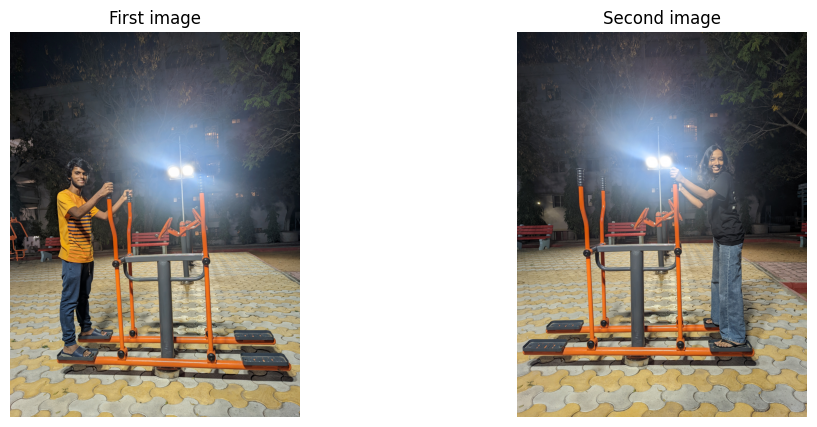

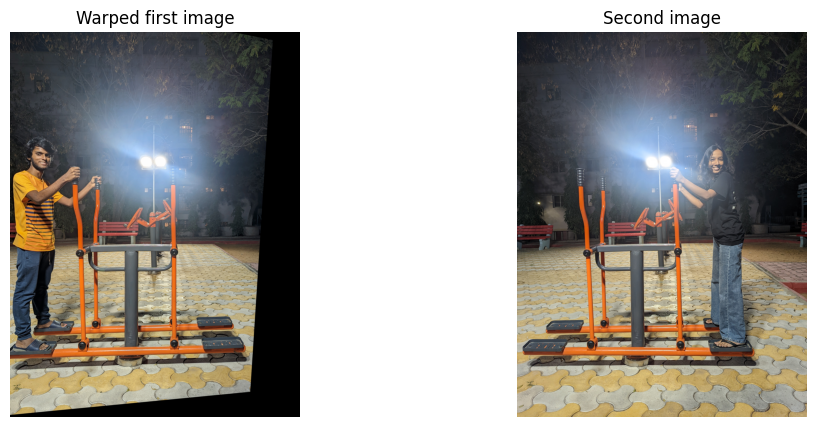

In [66]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
show_image(man, "First image")
plt.subplot(122)
show_image(man2, "Second image")

plt.figure(figsize=(12, 5))
plt.subplot(121)
show_image(warped_man, "Warped first image")
plt.subplot(122)
show_image(man2, "Second image")

In [67]:
man = warped_man
man2 = man2

## Haar cascade face detection

In [74]:
def findBoundingBoxFace(img):
    # using cv2 cascade classifier
    face_cascade = cv.CascadeClassifier()
    face_cascade.load(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(img, 1.3, 5)

    if(len(faces) == 0):
        return None
    bigFace = (0, 0, 0, 0)
    for i in range(len(faces)):
        if(faces[i][2]*faces[i][3] > bigFace[2]*bigFace[3]):
            bigFace = faces[i]
    (x, y, w, h) = bigFace
    return (x, y, w, h)

In [75]:
def findBoundingBoxes(img,type="far"):
    face_box = findBoundingBoxFace(img)

    try:
        assert face_box != None
    except AssertionError as e:
        print("No face found")
        raise(e)
    
    (x, y, w, h) = face_box
    if(type == "far"):
        (xb, yb, wb, hb) = (x-w, y-h, 3*w, img.shape[0] - y +h)
    elif(type == "near"):
        (xb, yb, wb, hb) = (int(x-1.5*w), y-2*h, 4*w, img.shape[0])
    
    return (xb, yb, wb, hb), (x, y, w, h)

In [76]:
def getLeftRight(man,man2):
    face_box = findBoundingBoxFace(man)
    try:
        assert face_box != None
    except AssertionError as e:
        print("No face found")
        raise(e)

    (x, y, w, h) = face_box

    face_box_2 = findBoundingBoxFace(man2)
    try:
        assert face_box_2 != None
    except AssertionError as e:
        print("No face found")
        raise(e)

    (x2, y2, w2, h2) = face_box_2

    if(x < x2):
        return man, man2
    else:
        return man2, man

In [77]:
def displayBoundingBoxes(img, body, face, title=...):
    if(title == ...):
        title = "Image with bounding boxes"
    boxMan = img.copy()

    (xb, yb, wb, hb), (x, y, w, h) = body, face
    cv.rectangle(boxMan, (xb, yb), (xb+wb, yb+hb), (0, 255, 0), 3)
    cv.rectangle(boxMan, (x, y), (x+w, y+h), (255, 0, 0), 3)

    show_image(boxMan, title)
    return boxMan
    

## Checking for overlap

In [78]:
def findSubjectType(man_left, man_right):
    body, face = findBoundingBoxes(man_left)

    body2, face2 = findBoundingBoxes(man_right)

    (x1, y1, w1, h1) = face
    (xb1, yb1, wb1, hb1) = body
    (x2, y2, w2, h2) = face2
    (xb2, yb2, wb2, hb2) = body2

    if(xb1+wb1 >= xb2):
        return "near"
    else:
        return "far"

### Test of Haar classifier wrt type of subject

In [79]:
man_left, man_right = getLeftRight(man, man2)
param = findSubjectType(man_left, man_right)
print(param)

far


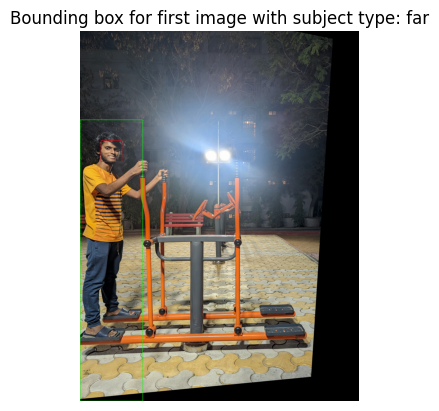

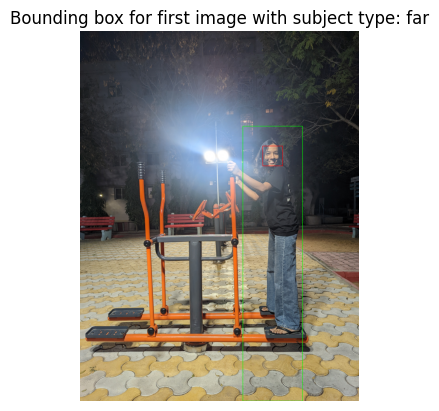

In [80]:
param = findSubjectType(man_left, man_right)

boxMan = man_left.copy()
body, face = findBoundingBoxes(man_left, param)
boxMan = displayBoundingBoxes(man_left, body, face, "Bounding box for first image with subject type: " + param)

plt.figure()
boxMan2 = man_right.copy()
body2, face2 = findBoundingBoxes(man_right, param)
boxMan = displayBoundingBoxes(man_right, body2, face2,"Bounding box for first image with subject type: " + param)

## Combining the images

### Alpha blend for far away subjects

In [82]:
# Blends between columns start and end
def alpha_blend(img_left, img_right, start, end):
    end = end+1  # Include the last column in computation
    step_size = 1.0/(end-start)
    img_left_cut = img_left[:,start:end,:]
    img_right_cut = img_right[:,start:end,:]
    
    alpha = np.arange(0, end-start)*step_size
    alpha = np.reshape(alpha,(1,-1,1))

    out_mid = img_left_cut*(1-alpha) + img_right_cut*(alpha)
    
    out = img_left.copy()
    out[:,start:end,:] = out_mid
    out[:,end:,:] = img_right[:,end:,:]

    return out

### Grab-Cut for subjects nearby

In [83]:
def grabCut(img1, img2, rect1, rectb1, rect2, rectb2):
    (x1, y1, w1, h1) = rect1
    (xb1, yb1, wb1, hb1) = rectb1
    (x2, y2, w2, h2) = rect2
    (xb2, yb2, wb2, hb2) = rectb2

    front = img1.copy()
    back = img2.copy()

    if(w2*h2 > w1*h1):
        front = img2.copy()
        back = img1.copy()
        (xb1, yb1, wb1, hb1), (x1, y1, w1, h1), (xb2, yb2, wb2, hb2), (x2, y2, w2, h2) = (xb2, yb2, wb2, hb2), (x2, y2, w2, h2), (xb1, yb1, wb1, hb1), (x1, y1, w1, h1)

    # create mask
    mask = np.zeros(front.shape[:2], np.uint8)
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    rect = (xb1, yb1, wb1, hb1)
    cv.grabCut(front,mask,rect,bgdModel,fgdModel,6,cv.GC_INIT_WITH_RECT)
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    cropped = front*mask2[:,:,np.newaxis]

    return mask2, back, front, cropped
        

In [84]:
def erodeWithEllipse(cropped):
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))
    eroded = cv.erode(cropped, kernel, iterations=1)
    return eroded

In [85]:
def blend_far(mask, cropped, back):
    blended = back.copy()
    blended[mask==1] = cropped[mask==1]
    return blended

## Blending the images

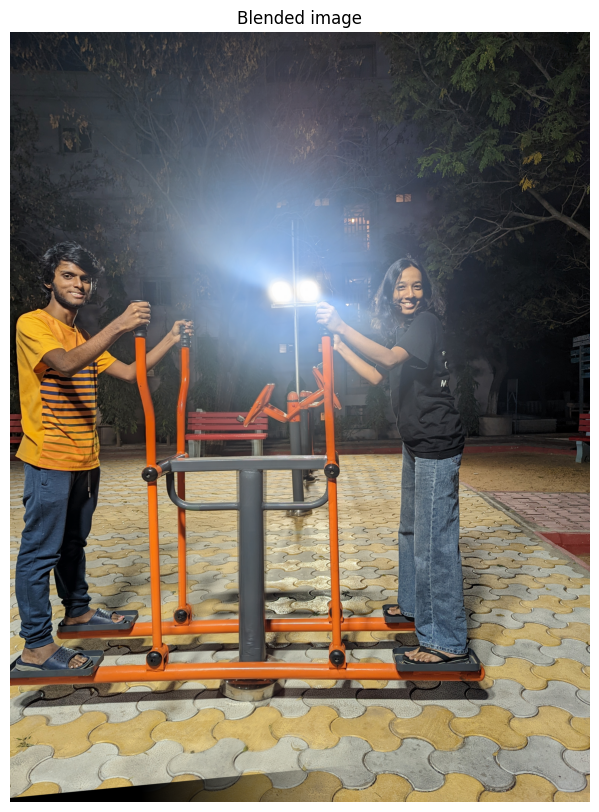

In [86]:
if(param == "far"):
    (xb, yb, wb, hb), (x, y, w, h) = body, face
    (xb2, yb2, wb2, hb2), (x2, y2, w2, h2) = body2, face2
    blended_out = alpha_blend(man_left, man_right, xb+wb, xb2)
    plt.figure(figsize=(20, 10))
    show_image(blended_out, "Blended image")
    imageName = 'out' + str(image_num) + '.png'
    cv.imwrite('../data/outs/'+imageName, cv.cvtColor(blended_out, cv.COLOR_RGB2BGR))

else:
    mask, back, front, cropped = grabCut(man, man2, face, body, face2, body2)
    # cropped = erodeWithEllipse(cropped)

    temp_cropped = cropped.copy()
    temp_cropped[cropped<0]=0
    show_image(temp_cropped, "Cropped")
    plt.figure()
    show_image(back, "Back")
    plt.show()
    
    blended = blend_far(mask, cropped, back)

    imageName = 'out' + str(image_num) + '.png'

    show_image(blended, "Blended")
    cv.imwrite('../data/outs/'+imageName, cv.cvtColor(blended, cv.COLOR_RGB2BGR))
